In [1]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

In [2]:
class SMnet(nn.Module):
    def __init__(self):
        super(SMnet, self).__init__()
        self.linear_start1 = nn.Linear(20,128)#20,128
        self.linear_start2 = nn.Linear(128,256)#128,256
        #self.linear_start1.cuda()
        #self.linear_start2.cuda()
        self.lstm = nn.LSTM(
            input_size=256, 
            hidden_size=512, 
            num_layers=3,
            batch_first=True)#256,512,3
        
       # self.lstm.cuda()
        self.linear1 = nn.Linear(512, 256)#512,256
        self.linear2 = nn.Linear(256, 3)#256,3
        #self.linear1.cuda()
        #self.linear2.cuda()
        
    def forward(self, robot_sensors):
        ls_out1 = self.linear_start1(robot_sensors)
        ls_out2 = self.linear_start2(ls_out1)
        lstm_out, (h_n, h_c) = self.lstm(ls_out2)
        l_out1 = self.linear1(lstm_out)
        l_out2 = self.linear2(l_out1)

        return l_out2
        

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt

data_x= pd.read_csv('joints_tobar.txt',delimiter=" ",header=None)
data_y= pd.read_csv('ground_truth.txt',delimiter=" ",header=None)
feat=data_x.as_matrix()
gtruth=data_y.as_matrix()

print('{0:2d} datos de entrada con tamaño {1:2d}'.format(len(feat),len(feat[0])))
print('{0:2d} datos de salida con tamaño {1:2d}'.format(len(gtruth),len(gtruth[0])))
y=[]
x=[]
v=[]
time=[]
#print(ground_t)
#Extraer x,y,z
for i in range(0,len(feat)):
    xi=[]
    for j in range(1,len(feat[0])):
        xi.append(feat[i][j])
    x.append(xi)
    time.append(feat[i][0])
    #if i%10000==0:
        #print(xi)
        
for i in range(0,len(gtruth)):
    pos=[]
    pos.append(gtruth[i][1])
    pos.append(gtruth[i][2])
    pos.append(gtruth[i][3])
    y.append(pos)
    #if i%10000==0:
        #print(pos)

for i in range(0,len(gtruth)-1):
    vel=[]
    vel.append(gtruth[i+1][1]-gtruth[i][1])
    vel.append(gtruth[i+1][2]-gtruth[i][2])
    vel.append(gtruth[i+1][3]-gtruth[i][3])
    v.append(pos)

y=v
        
print('{0:2d} datos de entrada con tamaño {1:2d}'.format(len(x),len(x[0])))
print('{0:2d} datos de salida con tamaño {1:2d}'.format(len(y),len(y[0])))

46874 datos de entrada con tamaño 21
46874 datos de salida con tamaño  8
46874 datos de entrada con tamaño 20
46873 datos de salida con tamaño  3


tamaño características de entrenamiento: 10000
tamaño características de validacion: 11873
--------------------------------------------------------------------
tamaño groundtruth de entrenamiento: 10000
tamaño groundtruth de validacion: 11873


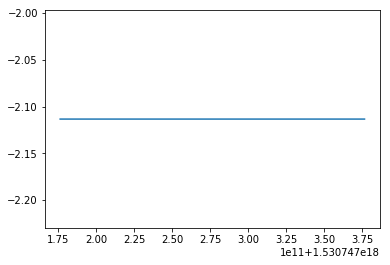

In [4]:
x_train= x[:10000]
y_train= y[:10000]
t_train=time[:10000]



y_plot=[]
for i in range(0,len(y_train)):
    y_plot.append(y_train[i][0])

plt.plot(t_train,y_plot)
    
x_val = x[35000:len(x)-1]
y_val = y[35000:]
t_val=time[35000:len(x)-1]
print('tamaño características de entrenamiento: {0:2d}'.format(len(x_train)))
print('tamaño características de validacion: {0:2d}'.format(len(y_val)))
print('--------------------------------------------------------------------')
print('tamaño groundtruth de entrenamiento: {0:2d}'.format(len(x_train)))
print('tamaño groundtruth de validacion: {0:2d}'.format(len(y_val)))

In [5]:
import sklearn as skl
std_scale=skl.preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_val = std_scale.transform(x_val)
std_scale=skl.preprocessing.StandardScaler().fit(y)
y_train = std_scale.transform(y_train)
y_val = std_scale.transform(y_val)
#np.interp(a, (a.min(), a.max()), (-1, +1))

In [6]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
input= torch.from_numpy(np.array(x_train))
target = torch.from_numpy(np.array(y_train))
#target = target.unsqueeze(0)
test_input = torch.from_numpy(np.array(x_val))
test_target = torch.from_numpy(np.array(y_val))
# build the model
sm = SMnet()
sm.double()
criterion = nn.L1Loss(size_average=False)
# create your optimizer
optimizer = optim.SGD(sm.parameters(), lr=0.001, momentum=0.9)

C:\Users\Giopa\Anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [7]:
# in your training loop:
batch_size=5
for i in range(500):
    optimizer.zero_grad()   # zero the gradient buffers
    batch = input[i:i+batch_size,:]
    batch = batch.unsqueeze(0)
    #print(batch.size())
    batch_target = target[i:i+batch_size,:]
    batch_target = batch_target.unsqueeze(0)
    output = sm(batch)
    loss = criterion(output, batch_target)
    print("loss: {}   ({}%)".format(loss,(i/5)))
    loss.backward()
    optimizer.step() # Does the update

loss: 15.450243839336473   (0.0%)
loss: 15.331489815593942   (0.2%)
loss: 15.105778062695503   (0.4%)
loss: 14.78357317011622   (0.6%)
loss: 14.374276236674966   (0.8%)
loss: 13.8860937338757   (1.0%)
loss: 13.323854898408753   (1.2%)
loss: 12.697484539700373   (1.4%)
loss: 12.009627454543152   (1.6%)
loss: 11.263505995635501   (1.8%)
loss: 10.46122429776189   (2.0%)
loss: 9.603469471545978   (2.2%)
loss: 8.689470120129524   (2.4%)
loss: 7.717535631392428   (2.6%)
loss: 6.684345287371707   (2.8%)
loss: 5.5854380690330325   (3.0%)
loss: 4.41514495213098   (3.2%)
loss: 3.166284721779133   (3.4%)
loss: 1.830089447611899   (3.6%)
loss: 0.4894557897476963   (3.8%)
loss: 1.058725235794167   (4.0%)
loss: 2.1728083883442046   (4.2%)
loss: 2.952489469557986   (4.4%)
loss: 3.4093660662398637   (4.6%)
loss: 3.5707115663838684   (4.8%)
loss: 3.465123812281677   (5.0%)
loss: 3.1263980081628673   (5.2%)
loss: 2.590036237648277   (5.4%)
loss: 1.8922951503778893   (5.6%)
loss: 1.0685177188870687   (5.

KeyboardInterrupt: 

In [ ]:
sm.eval()

In [ ]:
print(input.size())

In [ ]:
Z = sm(input.unsqueeze(0))

In [ ]:
Z=Z.view(-1,3)
print(Z)

In [ ]:
    x_pred,x_true=[],[]
    y_pred,y_true=[],[]
    z_pred,z_true=[],[]
    for k in range(0,len(y_val)):
        x_pred.append(Z[k][0].item())
        x_true.append(y_train[k][0].item())
        y_pred.append(Z[k][1])
        y_true.append(y_train[k][1])
        z_pred.append(Z[k][2])
        z_true.append(y_train[k][2])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(x_true, x_pred))
print('x RMSE: {}'.format(rms)) # Sin normalizar: 2.01914| Con normalizar: 2.0322

rms = sqrt(mean_squared_error(y_true, y_pred))
print('y RMSE: {}'.format(rms)) # Sin normalizar: 0.6174| Con normalizar: 0.6184

rms = sqrt(mean_squared_error(z_true, z_pred))
print('z RMSE: {}'.format(rms)) # Sin normalizar: 0.1204| Con normalizar: 0.1091

print('-----------------------------------')
print('Partida ajustada manual')

x_p,y_p,z_p=[],[],[]

for i in range(0,len(x_pred)):
    x_p.append(x_pred[i])
    y_p.append(y_pred[i])
    z_p.append(z_pred[i])

rms = sqrt(mean_squared_error(x_true, x_p))
print('x RMSE: {}'.format(rms)) # Sin normalizar: 2.01914| Con normalizar: 2.0322

rms = sqrt(mean_squared_error(y_true, y_p))
print('y RMSE: {}'.format(rms)) # Sin normalizar: 2.01914| Con normalizar: 2.0322

rms = sqrt(mean_squared_error(z_true, z_p))
print('z RMSE: {}'.format(rms)) # Sin normalizar: 2.01914| Con normalizar: 2.0322





import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
#plt.plot(t_val,x_pred,'b')
plt.plot(t_val,x_true,'r')
#plt.plot(t_val,x_p,'g')
plt.title('X[t]')
plt.legend(['prediction','true','manual'])
plt.show()

plt.figure(figsize=(10,5))
#plt.plot(t_val,y_pred,'b')
plt.plot(t_val,y_true,'r')
#plt.plot(t_val,y_p,'g')
plt.title('Y[t]')
plt.legend(['prediction','true','manual'])
plt.show()

plt.figure(figsize=(10,5))
#plt.plot(t_val,z_pred,'b')
plt.plot(t_val,z_true,'r')
#plt.plot(t_val,z_p,'g')
plt.title('Z[t]')
plt.legend(['prediction','true','manual'])
plt.show()